## Реалізація функцій для перевірки вибірки на нормальність

В своїй роботі для перевірки нормальності я планую застосовувати один з двох тестів:

+ [normaltest](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html) - This function tests the null hypothesis that a sample comes from a normal distribution. It is based on D’Agostino and Pearson’s test that combines skew and kurtosis to produce an omnibus test of normality.
+ [shapiro](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html) - The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution. The algorithm used is described in but censoring parameters as described are not implemented. For N > 5000 the W test statistic is accurate but the p-value may not be. The chance of rejecting the null hypothesis when it is true is close to 5% regardless of sample size.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import scipy.stats as stats


def normality_test(x, method='normaltest', **kwargs):
    '''
    method is in {'normaltest', 'shapiro', ...}
    '''
    test = getattr(stats, method)
    return test(x, **kwargs)
     

## Реалізація kNN

In [3]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.spatial import distance_matrix


class KNearestNeighbor(BaseEstimator, ClassifierMixin):
    
    def __init__(self, n_neighbors: int = 1, p: int = 2, use_proportion=False,):
        self.n_neighbors = n_neighbors
        self.p = p
        self.use_proportion = use_proportion

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        if self.use_proportion:
            self.proportions = np.unique(y, return_counts=True)[1] / len(y)

    def predict(self, X):
        return self._predict_labels(distance_matrix(X, self.X_train, p=self.p))

    def _predict_labels(self, dists):
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            y_ind = np.argsort(dists[i, :], axis=0)
            closest_y = self.y_train[y_ind[:self.n_neighbors]]
            
            if self.use_proportion:
                bins = np.bincount(closest_y)
                y_pred[i] = np.argmax(bins * self.proportions[:len(bins)])
            else:
                y_pred[i] = np.argmax(np.bincount(closest_y))

        return y_pred

## Реалізація Naive Bayes

Щільність розподілу $\mathcal{N}(\mu, \sigma^2)$ має настпуний вигляд:
$$
f(x|\mu, \sigma^2) = \frac{1}{\sigma\sqrt{2\pi}}\exp(-\frac{(x - \mu)^2}{2\sigma^2})
$$

Реалізуємо відповідний клас:

In [4]:
class GaussianDistribution:
    def __init__(self, feature):
        self.mean = feature.mean(axis=0)
        self.std = feature.std(axis=0)

    def logpdf(self, value):
        '''Logarithm of probability density at value'''
        return -np.log(np.pi*2*(self.std**2)) / 2 - np.power(value - self.mean, 2) / (2*(self.std**2))
    
    def pdf(self, value):
        return np.exp(self.logpdf(value))


Наші фічі можуть мати будь-який розподіл, не обовʼязково нормальний. Тому, можемо імплементувати Kernel Density Estimator (KDE) з ядром Гауса, для оцінки щільності довільного розподілу. Ідея цього методу проста: ми пробігаємось вікном та оцінюємо щільність розподілу в заданому вікні, використовуючи певне ядро.

In [5]:
from sklearn.neighbors import KernelDensity


class GaussianKDE:
    def __init__(self, feature, bandwidth=1.):
        self.kde = KernelDensity(bandwidth=bandwidth)
        self.kde.fit(feature.reshape((-1, 1)))

    def logpdf(self, value):
        return self.kde.score_samples(value.reshape((-1, 1)))

    def pdf(self, value):
        return np.exp(self.log_proba(value))

Ми маємо $K$ з таргетом $y_i \in \{C_1, \ldots, C_k\}$. В такому випадку, для вирішення поставленої задачі класифікації, теорема Баєса набуває наступної форми:

$$
P(y_i = C_k|\mathbf{x}_i) = \frac{P(\mathbf{x}_i|y_i = C_k) P(y_i = C_k)}{P(\mathbf{x}_i)}
$$

Звісно, зручніше працювати з логарифмом даної формули. Тоді вираз набуває наступної форми:
$$
\log P(y_i = C_k|\mathbf{x}_i) = \log P(\mathbf{x}_i|y_i = C_k) + \log P(y_i = C_k) - \log P(\mathbf{x}_i)
$$

Як ми можемо бачити, щоб знайти клас з найбільшою ймовірністю нам не потрібно шукати $P(\mathbf{x}_i)$. Але якщо ми хочемо знайти не просто клас, а оцінити ймовірність $P(y_i = C_k|\mathbf{x}_i)$, тоді все таки нам потрібно обрахувати цей спільний член $P(\mathbf{x}_i)$. Він може бути обрахований, з використанням наступної властивості:
$$
P(\mathbf{x}_i) = \sum_{k=1}^K P(\mathbf{x}_i|y_i=C_k).
$$

В цілому, це все що потрібно для реалізації:

In [6]:
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.special import logsumexp


class NaiveBayes(BaseEstimator, ClassifierMixin):

    def fit(self, X, y, sample_weight=None, distributions=None):
        self.unique_labels = np.unique(y)
        
        # If distributions of features are not specified, they a treated Gaussian
        if distributions is None:
            distributions = [GaussianDistribution] * X.shape[1]
        else:
            # Check whether distributions are passed for all features
            assert len(distributions) == X.shape[1]        

        # Here we find distribution parameters for every feature in every class subset
        # so P(x^i|y=C_k) will be estimated only using information from i-th feature of C_k class values
        self.conditional_feature_distributions = {} # label: [distibution for feature 1, ...]
        for label in self.unique_labels:
            feature_distribution = []
            for column_index in range(X.shape[1]):
                # `column_index` feature values for objects from `label` class
                feature_column = X[y == label, column_index]
                fitted_distr = distributions[column_index](feature_column)
                feature_distribution.append(fitted_distr)
            self.conditional_feature_distributions[label] = feature_distribution

        # Prior label distributions (unconditional probability of each class)
        self.prior_label_distibution = {
            label: np.sum((y == label).astype(float)) / len(y)
            for label in self.unique_labels
        }

    def predict_log_proba(self, X):
        # Matrix of shape (n_objects : n_classes)
        class_log_probas = np.zeros((X.shape[0], len(self.unique_labels)), dtype=float)
        
        # Here we compute the class log probabilities for each class sequentially
        for label_idx, label in enumerate(self.unique_labels):
            for idx in range(X.shape[1]):
                # All loglikelihood for every feature w.r.t. fixed label
                class_log_probas[:, label_idx] += self.conditional_feature_distributions[label][idx].logpdf(X[:, idx])

            # Add log proba of label prior
            class_log_probas[:, label_idx] += np.log(self.prior_label_distibution[label])

        for idx in range(X.shape[1]):
            # If you want to get probabilities, you need to substract the log proba for every feature
            class_log_probas -= logsumexp(class_log_probas, axis=1)[:,None]
        return class_log_probas
    
    def predict_proba(self, X):
        return np.exp(self.predict_log_proba(X))
    
    def predict(self, X):
        log_probas = self.predict_log_proba(X)
        # we need to cast labels to their original form (they may start from number other than 0)
        return np.array([self.unique_labels[idx] for idx in log_probas.argmax(axis=1)])

## Завантаження необхідних даних та їх обробка

In [7]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, balanced_accuracy_score, ConfusionMatrixDisplay, confusion_matrix

In [8]:
sns.set(style="ticks", context="talk")

seed = 42

In [9]:
df = pd.read_csv('cancer.csv')
df.shape

(51, 75)

In [10]:
df.head()

,State,Total.Rate,Total.Number,Total.Population,Rates.Age.< 18,Rates.Age.18-45,Rates.Age.45-64,Rates.Age.> 64,Rates.Age and Sex.< 18.Female,Rates.Age and Sex.< 18.Male,...,Types.Lung.Age and Sex.Male.45 - 64,Types.Lung.Age and Sex.Female.> 64,Types.Lung.Age and Sex.Male.> 64,Types.Lung.Race.White,Types.Lung.Race.White non-Hispanic,Types.Lung.Race.Black,Types.Lung.Race.Black non-Hispanic,Types.Lung.Race.Asian,Types.Lung.Race.Indigenous,Types.Lung.Race.Hispanic
0,Alabama,214.2,71529.0,33387205.0,2.0,18.5,244.7,1017.8,2.0,2.1,...,102.9,221.7,457.4,59.9,60.4,52.6,52.8,23.0,22.9,14.8
1,Alaska,128.1,6361.0,4966180.0,1.7,11.8,170.9,965.2,0.0,0.0,...,50.3,268.3,335.0,48.7,49.5,45.6,47.9,33.0,74.4,0.0
2,Arizona,165.6,74286.0,44845598.0,2.5,13.6,173.6,840.2,2.6,2.5,...,47.0,191.9,275.8,39.5,42.2,38.2,40.4,21.3,11.1,21.6
3,Arkansas,223.9,45627.0,20382448.0,2.3,17.6,250.1,1048.3,2.6,2.0,...,106.5,248.7,484.7,63.4,64.2,62.9,63.0,18.1,16.2,14.6
4,California,150.9,393980.0,261135696.0,2.6,13.7,163.7,902.4,2.4,2.8,...,36.8,192.5,269.0,37.2,42.6,46.5,48.6,25.8,18.4,18.3


In [11]:
df.describe()

,Total.Rate,Total.Number,Total.Population,Rates.Age.< 18,Rates.Age.18-45,Rates.Age.45-64,Rates.Age.> 64,Rates.Age and Sex.< 18.Female,Rates.Age and Sex.< 18.Male,Rates.Age and Sex.18 - 45.Female,...,Types.Lung.Age and Sex.Male.45 - 64,Types.Lung.Age and Sex.Female.> 64,Types.Lung.Age and Sex.Male.> 64,Types.Lung.Race.White,Types.Lung.Race.White non-Hispanic,Types.Lung.Race.Black,Types.Lung.Race.Black non-Hispanic,Types.Lung.Race.Asian,Types.Lung.Race.Indigenous,Types.Lung.Race.Hispanic
count,51.000000,51.000000,5.100000e+01,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,...,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,190.656863,78723.725490,4.240151e+07,2.119608,14.764706,197.576471,980.949020,1.727451,2.033333,16.013725,...,64.825490,224.668627,354.956863,48.158824,49.341176,44.056863,44.500000,19.323529,27.309804,16.184314
std,28.592155,80861.292676,4.784244e+07,0.502004,2.204343,31.261040,75.189556,0.846186,0.931808,2.530219,...,21.288737,33.313394,69.938477,9.446125,9.274183,20.517283,21.431435,10.427801,26.435236,8.041079
min,98.500000,6361.000000,3.931624e+06,0.000000,10.000000,132.300000,735.800000,0.000000,0.000000,10.300000,...,26.000000,92.700000,153.200000,20.400000,20.600000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,176.500000,20631.000000,1.186991e+07,2.050000,13.350000,175.000000,943.550000,1.750000,2.050000,14.150000,...,48.950000,209.550000,313.300000,42.750000,43.700000,38.150000,39.950000,18.350000,4.450000,13.700000
50%,196.100000,54930.000000,3.034806e+07,2.200000,14.600000,189.300000,999.600000,2.000000,2.300000,16.000000,...,59.700000,225.800000,342.600000,48.100000,48.800000,47.000000,48.600000,22.200000,20.900000,18.100000
75%,210.750000,93328.000000,4.650326e+07,2.400000,16.250000,217.850000,1031.450000,2.200000,2.500000,17.700000,...,77.600000,248.150000,391.000000,54.500000,54.950000,60.000000,60.350000,25.500000,44.250000,20.450000
max,254.600000,393980.000000,2.611357e+08,2.700000,20.300000,263.900000,1110.200000,2.900000,3.200000,22.800000,...,112.600000,298.300000,519.100000,71.500000,71.900000,73.200000,73.600000,33.900000,87.500000,35.200000


In [12]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=seed)
df_train.shape, df_test.shape

((40, 75), (11, 75))

## Завдання №1

Взяти колонки **Rates.Age.18-45**, **Rates.Age.45-64**, **Rates.Age.> 64**. Перевірити спочатку дані на нормальніть і використати метод Байєса, якщо  вибірка не нормальна -- метод k найближчих суідів. 

In [13]:
alpha = 0.05
features_list = ['Rates.Age.18-45', 'Rates.Age.45-64', 'Rates.Age.> 64']
TARGET = 'Rates.Age and Sex.45 - 64.Female'

scaler = MinMaxScaler()

In [14]:
print('H_0: x comes from a normal distribution')
print('H_1: reject H_0')

for method in ('normaltest', 'shapiro',):
    print(f'Method - "{method}"')
    for feature in features_list:
        stat, p_val = normality_test(df_train[feature], method=method)
        if p_val < alpha:
            print(f'\t - ["{feature}", p_val={p_val:.3f}, stat={stat:.3f}] The null hypothesis can be rejected')
        else:
            print(f'\t - ["{feature}", p_val={p_val:.3f}, stat={stat:.3f}] The null hypothesis cannot be rejected')
            

H_0: x comes from a normal distribution
H_1: reject H_0
Method - "normaltest"
	 - ["Rates.Age.18-45", p_val=0.675, stat=0.785] The null hypothesis cannot be rejected
	 - ["Rates.Age.45-64", p_val=0.501, stat=1.382] The null hypothesis cannot be rejected
	 - ["Rates.Age.> 64", p_val=0.000, stat=17.453] The null hypothesis can be rejected
Method - "shapiro"
	 - ["Rates.Age.18-45", p_val=0.757, stat=0.982] The null hypothesis cannot be rejected
	 - ["Rates.Age.45-64", p_val=0.123, stat=0.956] The null hypothesis cannot be rejected
	 - ["Rates.Age.> 64", p_val=0.000, stat=0.863] The null hypothesis can be rejected


In [15]:
X_train = scaler.fit_transform(df_train[features_list])
X_test = scaler.transform(df_test[features_list])

y_train = (df_train[TARGET] < 173.6).astype(int)
y_test = (df_test[TARGET] < 173.6).astype(int)

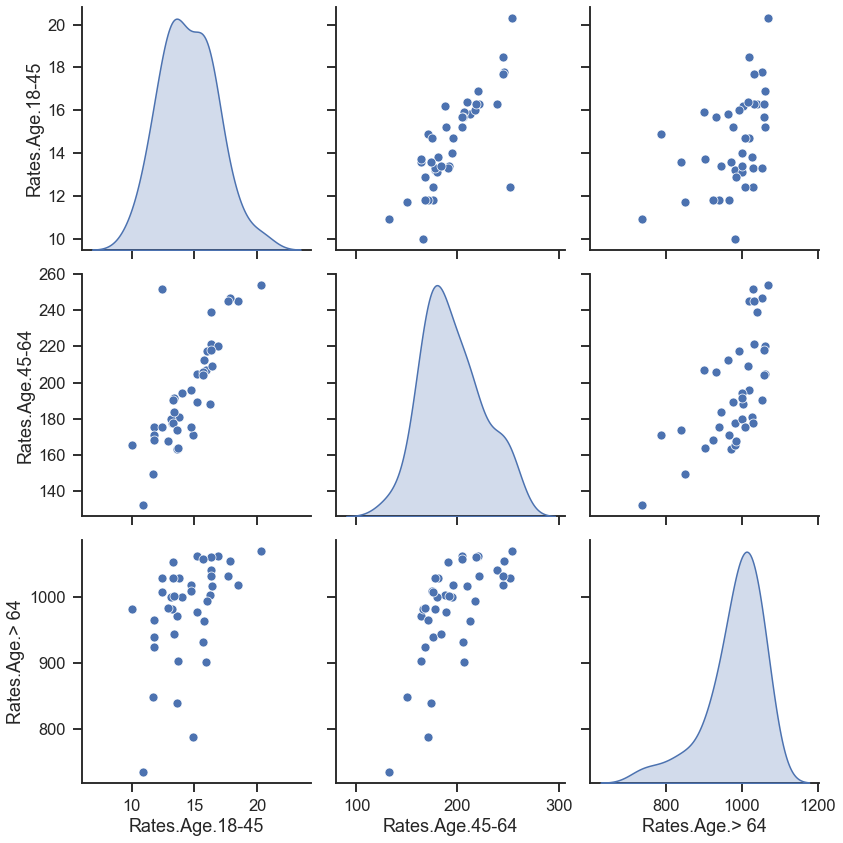

In [16]:
sns.pairplot(df_train[features_list], diag_kind='kde', height=4);

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11



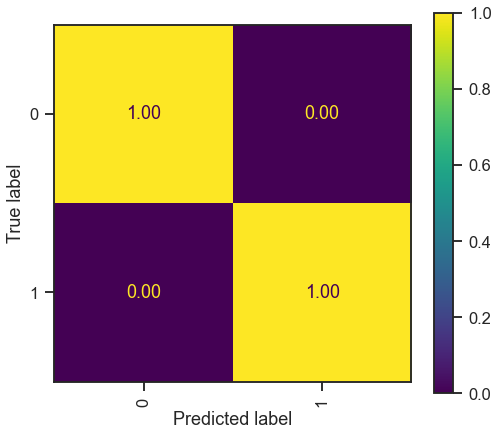

In [17]:
nb = NaiveBayes()
nb.fit(X_train, y_train, distributions=None)

y_pred = nb.predict(X_test)

print(classification_report(y_test, y_pred))

C = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=C / C.astype(np.float).sum(axis=1, keepdims=True),
)
disp.plot(xticks_rotation='vertical', values_format='.2f');

In [18]:
nb = NaiveBayes()
nb.fit(X_train, y_train, distributions=[GaussianKDE]*X_train.shape[1])

y_pred = nb.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11



## Завдання №2

Дослідити модель лінійної регреії.

Відгук:
+ Rates.Age and Sex.45 - 64.Female

Змінні регресії:
+ Types.Lung.Race.White
+ Types.Lung.Race.White non-Hispanic
+ Types.Lung.Race.Black
+ Types.Lung.Race.Black non-Hispanic

In [19]:
features_list = ['Types.Lung.Race.White', 'Types.Lung.Race.White non-Hispanic', 'Types.Lung.Race.Black', 'Types.Lung.Race.Black non-Hispanic']
TARGET = 'Rates.Age and Sex.45 - 64.Female'

scaler = MinMaxScaler()

### Побудуємо матрицю кореляцій:

In [20]:
df_train[features_list+[TARGET]].corr().style.background_gradient(cmap='coolwarm').set_precision(3)

,Types.Lung.Race.White,Types.Lung.Race.White non-Hispanic,Types.Lung.Race.Black,Types.Lung.Race.Black non-Hispanic,Rates.Age and Sex.45 - 64.Female
Types.Lung.Race.White,1.000,0.991,0.323,0.282,0.630
Types.Lung.Race.White non-Hispanic,0.991,1.000,0.341,0.304,0.613
Types.Lung.Race.Black,0.323,0.341,1.000,0.969,0.438
Types.Lung.Race.Black non-Hispanic,0.282,0.304,0.969,1.000,0.411
Rates.Age and Sex.45 - 64.Female,0.630,0.613,0.438,0.411,1.000


### Дослідимо модель лінійної регресії для `Rates.Age and Sex.45 - 64.Female`

In [21]:
import statsmodels.api as sm
from sklearn.linear_model import Ridge, Lasso

In [22]:
X_train = scaler.fit_transform(df_train[features_list])
X_test = scaler.transform(df_test[features_list])

y_train = df_train[TARGET].copy()
y_test = df_test[TARGET].copy()

In [23]:
X_train_ols = sm.add_constant(X_train)
X_test_ols = sm.add_constant(X_test)

In [24]:
model = sm.OLS(y_train, X_train_ols)
results = model.fit()
print(results.summary())

                                   OLS Regression Results                                   
Dep. Variable:     Rates.Age and Sex.45 - 64.Female   R-squared:                       0.476
Model:                                          OLS   Adj. R-squared:                  0.416
Method:                               Least Squares   F-statistic:                     7.954
Date:                              Mon, 20 Jun 2022   Prob (F-statistic):           0.000114
Time:                                      00:58:36   Log-Likelihood:                -167.35
No. Observations:                                40   AIC:                             344.7
Df Residuals:                                    35   BIC:                             353.1
Df Model:                                         4                                         
Covariance Type:                          nonrobust                                         
                 coef    std err          t      P>|t|      [0.025    

+ відкидаємо $H_0$ для F-test про те, що всі коефіцієнти регресії рівні нулю
+ модель має низький $R^2$ (доля дисперсії залежної змінної, яку модель може пояснити, використовуючи незалежні змінні)
+ для x1, x2, x3, x4 ми маємо p-value для t-test більше за 0.05, що означає прийняття нульової гіпотези про те, що немає залежності між відгуком та змінними регресії

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


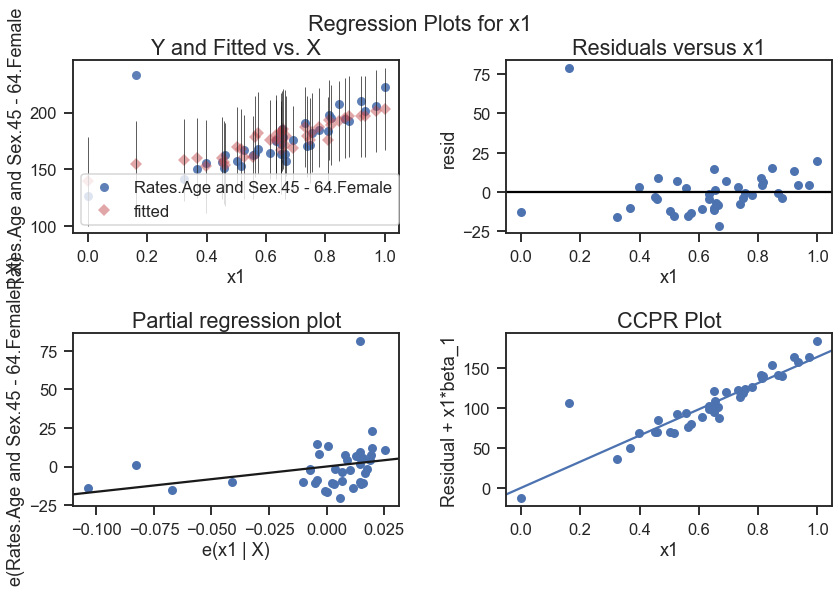

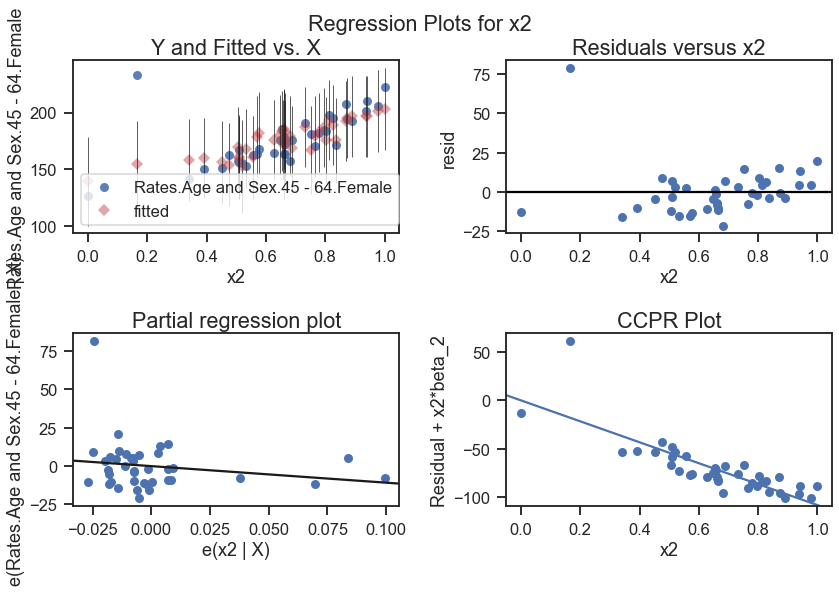

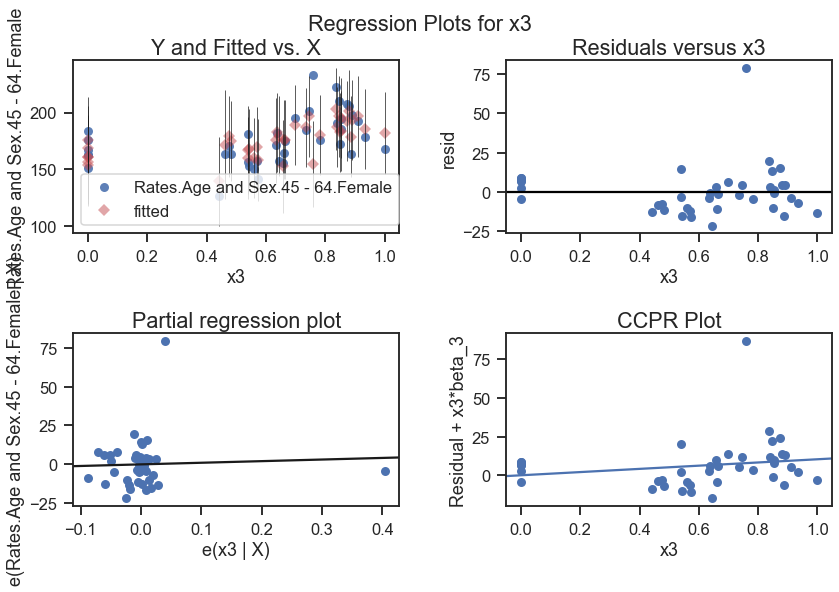

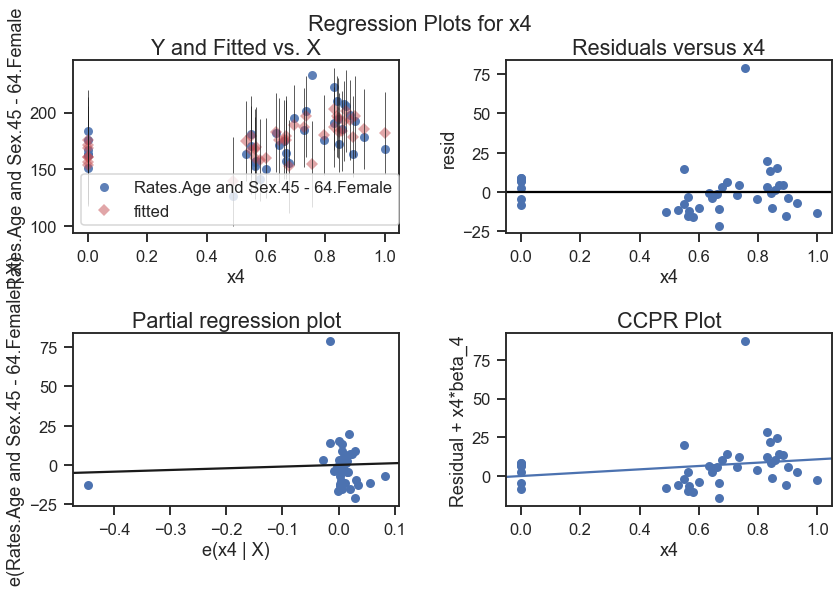

In [25]:
for idx in range(1, X_train.shape[1]+1):
    fig = plt.figure(figsize=(12,8))
    fig = sm.graphics.plot_regress_exog(results, f'x{idx}', fig=fig)

### Застосуємо лінійну регресію з L1 регуляризацією

In [26]:
model = Lasso().fit(X_train, y_train)

print('Intercept: \n', model.intercept_)
print('Coefficients: \n', model.coef_)
print('Score:', model.score(X_test, y_test))

Intercept: 
 144.52799318940774
Coefficients: 
 [37.60747007  0.         12.4392862   0.        ]
Score: 0.6736873360635764


### Застосуємо лінійну регресію з L2 регуляризацією

In [27]:
model = Ridge().fit(X_train, y_train)

print('Intercept: \n', model.intercept_)
print('Coefficients: \n', model.coef_)
print('Score:', model.score(X_test, y_test))

Intercept: 
 135.9080613447967
Coefficients: 
 [24.12285902 20.08374259 10.61630748  8.59042278]
Score: 0.7559019446114159


## Завдання №3

Як зробити класифікацію по етнічному принципу, використовуючи змінні **Types.Lung.Race.White**, **Types.Lung.Race.Black**.
Перевірити спочатку дані на нормальніть і використати метод Байєса, якщо  вибірка не нормальна -- метод k найближчих суідів. 

In [28]:
alpha = 0.05
features_list = ['Types.Lung.Race.White', 'Types.Lung.Race.Black']
TARGET = 'Rates.Age and Sex.45 - 64.Female'

scaler = MinMaxScaler()

In [29]:
print('H_0: x comes from a normal distribution')
print('H_1: reject H_0')

for method in ('normaltest', 'shapiro',):
    print(f'Method - "{method}"')
    for feature in features_list:
        stat, p_val = normality_test(df_train[feature], method=method)
        if p_val < alpha:
            print(f'\t - ["{feature}", p_val={p_val:.3f}, stat={stat:.3f}] The null hypothesis can be rejected')
        else:
            print(f'\t - ["{feature}", p_val={p_val:.3f}, stat={stat:.3f}] The null hypothesis cannot be rejected')
            

H_0: x comes from a normal distribution
H_1: reject H_0
Method - "normaltest"
	 - ["Types.Lung.Race.White", p_val=0.037, stat=6.572] The null hypothesis can be rejected
	 - ["Types.Lung.Race.Black", p_val=0.022, stat=7.660] The null hypothesis can be rejected
Method - "shapiro"
	 - ["Types.Lung.Race.White", p_val=0.172, stat=0.960] The null hypothesis cannot be rejected
	 - ["Types.Lung.Race.Black", p_val=0.000, stat=0.845] The null hypothesis can be rejected


In [30]:
X_train = scaler.fit_transform(df_train[features_list])
X_test = scaler.transform(df_test[features_list])

y_train = (df_train[TARGET] < 173.6).astype(int).values
y_test = (df_test[TARGET] < 173.6).astype(int).values

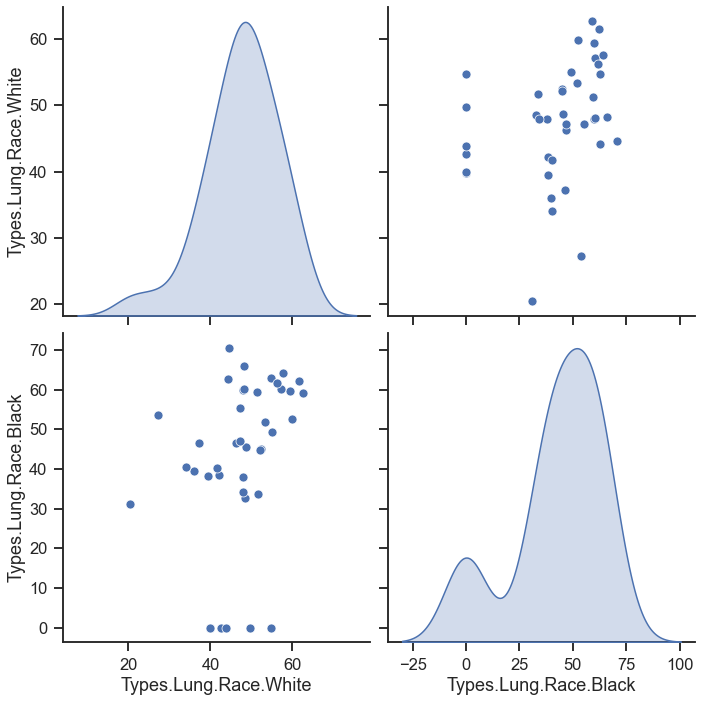

In [31]:
sns.pairplot(df_train[features_list], diag_kind='kde', height=5);

In [32]:
scores = []
neighbors_list = list(range(3, 16))
for n_neighbors in neighbors_list:
    knn_clf = KNearestNeighbor(n_neighbors=n_neighbors)
    knn_clf.fit(X_train, y_train);
    prediction = knn_clf.predict(X_test)
    
    scores.append(balanced_accuracy_score(y_test, prediction))

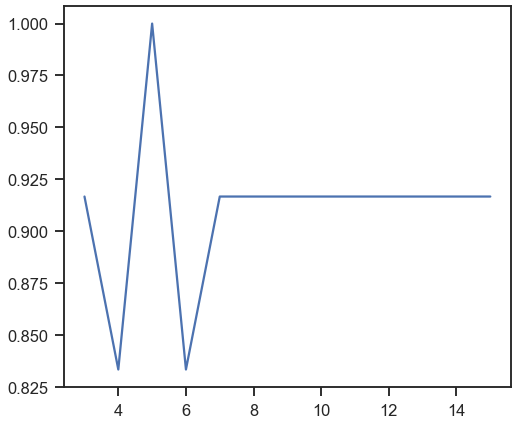

In [33]:
sns.lineplot(neighbors_list, scores);

n_neighbors = 5
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11



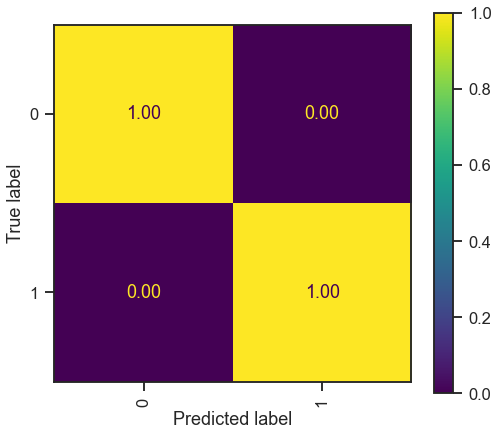

In [34]:
n_neighbors = max(zip(neighbors_list, scores), key=lambda x: x[1])[0]
print(f'n_neighbors = {n_neighbors}')
knn_clf = KNearestNeighbor(n_neighbors=n_neighbors)
knn_clf.fit(X_train, y_train);

prediction = knn_clf.predict(X_test)

C = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=C / C.astype(np.float).sum(axis=1, keepdims=True),
)
disp.plot(xticks_rotation='vertical', values_format='.2f');

print(classification_report(y_test, prediction))

## Trash

In [80]:
# N = X_train.shape[0]
# p = X_train.shape[1] + 1

# X_with_intercept = np.empty(shape=(N, p), dtype=np.float)
# X_with_intercept[:, 0] = 1
# X_with_intercept[:, 1:p] = X_train.copy()

# y_hat = model.predict(X_train)
# residuals = y_train.values - y_hat
# residual_sum_of_squares = residuals.T @ residuals
# sigma_squared_hat = residual_sum_of_squares / (N - p)
# var_beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) * sigma_squared_hat

# se = np.asarray([var_beta_hat[p_, p_] ** 0.5 for p_ in range(p)])

# w = np.asarray([model.intercept_] + model.coef_.tolist())
# t = w / se
# p = 1 - stats.t.cdf(np.abs(t), y_train.shape[0] - X_train.shape[1] - 1)

# pd.DataFrame({'w': w, 't': t, 'p-val': np.round(p, 3), 'p-val < 0.05': p < 0.05})